# Dynamic Risk Budgeting

In [5]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
price_eq = erk.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [14]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30"), 
], axis = 1).round(2)

,ZC,Eq,70/30
mean,1.34,2.00,1.77
std,0.00,1.05,0.63
p_breach,NaN,0.03,0.01
e_short,NaN,0.12,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [15]:
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocated between the PSP and GHP woth the gpal to provide exposure to the upside
    of the PSP without going violating the floor
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns = psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ## PV of floor assuming today's rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0,1) # .clip(0,1) is same as applying mix and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

In [16]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:])
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30",floor=0.75), 
    erk.terminal_stats(rets_floor75, name="Floor75",floor=0.75), 
], axis = 1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,2.00,1.77,1.98
std,0.00,1.05,0.63,1.06
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.12,0.08,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [23]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=5)
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30",floor=0.75), 
    erk.terminal_stats(rets_floor75, name="Floor75",floor=0.75), 
    erk.terminal_stats(rets_floor75m1, name="Floor75m1",floor=0.75),
    erk.terminal_stats(rets_floor75m5, name="Floor75m5",floor=0.75)
], axis = 1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5
mean,1.34,2.00,1.77,1.98,1.63,1.99
std,0.00,1.05,0.63,1.06,0.46,1.06
p_breach,NaN,0.03,0.01,NaN,NaN,0.01
e_short,NaN,0.12,0.08,NaN,NaN,0.01
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=5)
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30",floor=0.75), 
    erk.terminal_stats(rets_floor75, name="Floor75",floor=0.75), 
    erk.terminal_stats(rets_floor75m1, name="Floor75m1",floor=0.75),
    erk.terminal_stats(rets_floor75m5, name="Floor75m5",floor=0.75)
], axis = 1).round(5)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5
mean,1.34334,2.00189,1.77372,1.97963,1.63480,1.98871
std,0.00000,1.05142,0.62735,1.05687,0.46358,1.05907
p_breach,NaN,0.03420,0.00680,NaN,NaN,0.01240
e_short,NaN,0.12278,0.07956,NaN,NaN,0.01292
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
def drawdown_allocator(psp_r, ghp_r, maxdd, m=3):
    """
    Allocated between the PSP and GHP woth the gpal to provide exposure to the upside
    of the PSP without going violating the floor
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    peak_value = np.repeat(1, n_scenarios) ## new line compared to floor allocator
    w_history = pd.DataFrame(index=psp_r.index, columns = psp_r.columns)
    for step in range(n_steps):
        floor_value = (1-maxdd)*peak_value ## floor is based on the prev peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0,1) # .clip(0,1) is same as applying mix and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        peak_value = np.maximum(peak_value, account_value) 
        w_history.iloc[step] = psp_w
    return w_history

# Risk budgeting with Drawdown Constraints

In [30]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data = monthly_cashreturn, index = rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30",floor=0.75), 
    erk.terminal_stats(rets_floor75, name="Floor75",floor=0.75), 
    erk.terminal_stats(rets_floor75m1, name="Floor75m1",floor=0.75),
    erk.terminal_stats(rets_floor75m5, name="Floor75m5",floor=0.75),
    erk.terminal_stats(rets_maxdd25, name="MaxDD25",floor=0.75)
], axis = 1).round(5)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,MaxDD25
mean,1.34334,2.00189,1.77372,1.97963,1.63480,1.98871,1.64661
std,0.00000,1.05142,0.62735,1.05687,0.46358,1.05907,0.57448
p_breach,NaN,0.03420,0.00680,NaN,NaN,0.01240,NaN
e_short,NaN,0.12278,0.07956,NaN,NaN,0.01292,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.195229
1   -0.173846
2   -0.140779
3   -0.220264
4   -0.175541
Name: Max Drawdown, dtype: float64

In [33]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23510840348657044

C:\Users\gamou\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gamou\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gamou\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

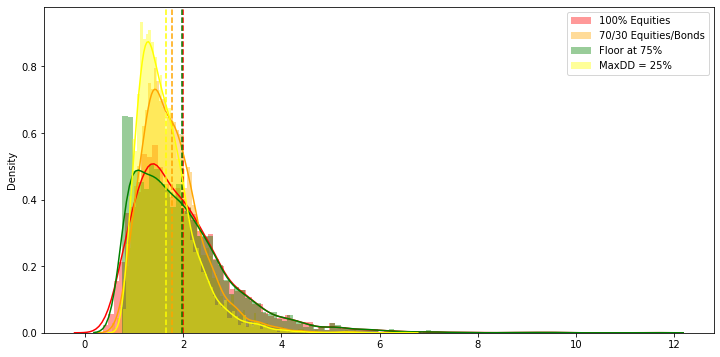

In [35]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

# plot
plt.figure(figsize=(12,6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

# Drawndown constrains with Historical Data

<AxesSubplot:>

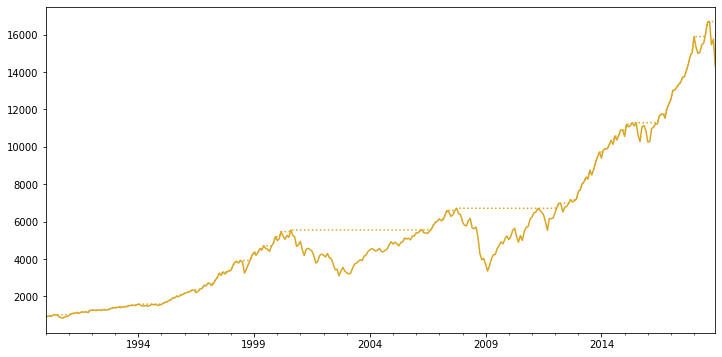

In [47]:
rets_tmi = erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color = "goldenrod")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

<AxesSubplot:>

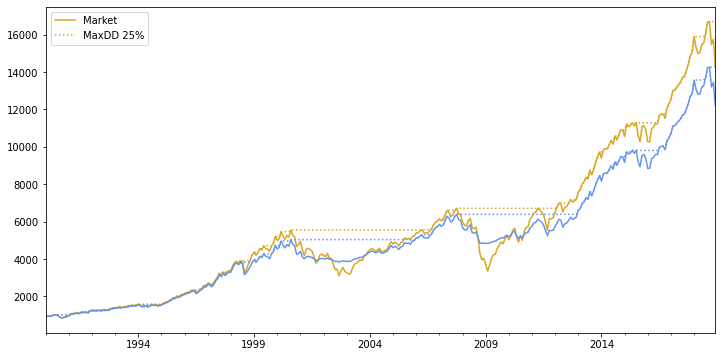

In [46]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data = monthly_cashreturn, index = rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color = "goldenrod", label="Market", legend=True)
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color = "cornflowerblue", legend=True)
dd_25["Peaks"].plot(ax=ax, color="cornflowerblue",ls=":")

In [49]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
